In [1]:
import numpy as np
import pandas as pd
import math
import numba, socket, time
import cudf
import dask, dask_cudf
import xgboost as xgb
import cuspatial
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster


# connect to the Dask cluster created at Dataproc startup time
cluster = LocalCUDACluster()
client = Client(cluster)
# forces workers to restart. useful to ensure GPU memory is clear
client.restart()

# # limit work-stealing as much as possible
# dask.config.set({'distributed.scheduler.work-stealing': False})
# dask.config.get('distributed.scheduler.work-stealing')
# dask.config.set({'distributed.scheduler.bandwidth': 1})
# dask.config.get('distributed.scheduler.bandwidth')

client

Client Scheduler: tcp://127.0.0.1:44993 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 100.01 GB


# Inspecting the Data

Now that we have a cluster of GPU workers, we'll use [dask-cudf](https://github.com/rapidsai/dask-cudf/) to load and parse a bunch of CSV files into a distributed DataFrame.

In [3]:
import os
os.getcwd()
base_path= os.getcwd()
df = dask_cudf.read_csv(base_path+ '/combined/'+'yellow_*.csv')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [6]:
len(df)

43614577

In [4]:
df.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RateCodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

# Data Cleanup

As usual, the data needs to be massaged a bit before we can start adding features that are useful to an ML model.

For example, in the 2014 taxi CSV files, there are `pickup_datetime` and `dropoff_datetime` columns. The 2015 CSVs have `tpep_pickup_datetime` and `tpep_dropoff_datetime`, which are the same columns. One year has `rate_code`, and another `RateCodeID`.

Also, some CSV files have column names with extraneous spaces in them.

Worst of all, starting in the July 2016 CSVs, pickup & dropoff latitude and longitude data were replaced by location IDs, making the second half of the year useless to us.

We'll do a little string manipulation, column renaming, and concatenating of DataFrames to sidestep the problems.

In [4]:
#list of column names that need to be re-mapped
remap = {}
remap['tpep_pickup_datetime'] = 'pickup_datetime'
remap['tpep_dropoff_datetime'] = 'dropoff_datetime'
remap['ratecodeid'] = 'rate_code'

#create a list of columns & dtypes the df must have
must_haves = {
 'pickup_datetime': 'M8[ns]',
 'dropoff_datetime': 'M8[ns]',
 'passenger_count': 'int32',
 'trip_distance': 'float32',
 'pickup_longitude': 'float32',
 'pickup_latitude': 'float32',
 'rate_code': 'int32',
 'dropoff_longitude': 'float32',
 'dropoff_latitude': 'float32',
 'fare_amount': 'float32'
}

In [5]:
def clean(df_part, remap, must_haves):    
    # some col-names include pre-pended spaces remove & lowercase column names
    tmp = {col:col.strip().lower() for col in list(df_part.columns)}
    df_part = df_part.rename(tmp)
    
    # rename using the supplied mapping
    df_part = df_part.rename(remap)
    
    # iterate through columns in this df partition
    for col in df_part.columns:
        # drop anything not in our expected list
        if col not in must_haves:
            df_part = df_part.drop(col)
            continue
        
        # fixes datetime error found by Ty Mckercher and fixed by Paul Mahler
        if df_part[col].dtype == 'object' and col in ['pickup_datetime', 'dropoff_datetime']:
            #df_part[col] = df_part[col].astype('datetime64[ms]')
            df_part[col] = df_part[col].astype('M8[ns]')
            continue
                
        # if column was read as a string, recast as float
        if df_part[col].dtype == 'object':
            df_part[col] = df_part[col].str.fillna('-1')
            df_part[col] = df_part[col].astype('float32')
        else:
            # downcast from 64bit to 32bit types
            # Tesla T4 are faster on 32bit ops
            if 'int' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('int32')
            if 'float' in str(df_part[col].dtype):
                df_part[col] = df_part[col].astype('float32')
            df_part[col] = df_part[col].fillna(-1)
    
    return df_part

In [6]:
taxi_df = df.map_partitions(clean, remap, must_haves, meta=must_haves)

In [7]:
taxi_df.dtypes

pickup_datetime      datetime64[ns]
dropoff_datetime     datetime64[ns]
passenger_count               int32
trip_distance               float32
pickup_longitude            float32
pickup_latitude             float32
rate_code                     int32
dropoff_longitude           float32
dropoff_latitude            float32
fare_amount                 float32
dtype: object

In [8]:
# apply a list of filter conditions to throw out records with missing or outlier values
query_frags = [
    'fare_amount > 1 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75 and pickup_longitude < -73',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42',
    'trip_distance > 0 and trip_distance < 500'
]
taxi_df = taxi_df.query(' and '.join(query_frags))

#filter out the abnormal data where trip distance is long, but the fare is very low.
mask = (taxi_df.trip_distance > 100) & (taxi_df.fare_amount < 50) 
taxi_df = taxi_df[~mask]

#filter out the abnormal data where trip distance is short, but the fare is very high.
mask = (taxi_df.trip_distance < 5) & (taxi_df.fare_amount > 300) 
taxi_df = taxi_df[~mask]

# check if there is any negative total trip time, and remove these records.
mask = (taxi_df.dropoff_datetime <= taxi_df.pickup_datetime)
taxi_df = taxi_df[~mask]

# inspect the results of cleaning
taxi_df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,-73.974785,40.750618,12.0
1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,-73.994415,40.759109,14.5
2,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,-73.951820,40.824413,9.5
3,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,-74.004326,40.719986,3.5
4,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,-74.004181,40.742653,15.0


# Adding Interesting Features

Dask & cuDF provide standard DataFrame operations, but also let you run "user defined functions" on the underlying data.

cuDF's [apply_rows](https://rapidsai.github.io/projects/cudf/en/0.6.0/api.html#cudf.dataframe.DataFrame.apply_rows) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels.

We'll use a Haversine Distance calculation to find total trip distance, and extract additional useful variables from the datetime fields.

In [10]:
## add features

taxi_df['hour'] = taxi_df['pickup_datetime'].dt.hour
taxi_df['year'] = taxi_df['pickup_datetime'].dt.year
taxi_df['month'] = taxi_df['pickup_datetime'].dt.month
taxi_df['day'] = taxi_df['pickup_datetime'].dt.day

#this line does not work
#taxi_df['diff'] = taxi_df['dropoff_datetime'].astype('int32') - taxi_df['pickup_datetime'].astype('int32')

#this is an alternative way.
taxi_df['diff'] = taxi_df['dropoff_datetime'].astype('int64') - taxi_df['pickup_datetime'].astype('int64')
taxi_df['diff']=(taxi_df['diff']/1000000000).astype('int64')

taxi_df['pickup_latitude_r'] = taxi_df['pickup_latitude']//.01*.01
taxi_df['pickup_longitude_r'] = taxi_df['pickup_longitude']//.01*.01
taxi_df['dropoff_latitude_r'] = taxi_df['dropoff_latitude']//.01*.01
taxi_df['dropoff_longitude_r'] = taxi_df['dropoff_longitude']//.01*.01

taxi_df = taxi_df.drop('pickup_datetime', axis=1)
taxi_df = taxi_df.drop('dropoff_datetime', axis=1)

In [11]:
taxi_df.dtypes

passenger_count          int32
trip_distance          float32
pickup_longitude       float32
pickup_latitude        float32
rate_code                int32
dropoff_longitude      float32
dropoff_latitude       float32
fare_amount            float32
hour                     int64
year                     int64
month                    int64
day                      int64
diff                     int64
pickup_latitude_r      float32
pickup_longitude_r     float32
dropoff_latitude_r     float32
dropoff_longitude_r    float32
dtype: object

In [12]:
taxi_df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,hour,year,month,day,diff,pickup_latitude_r,pickup_longitude_r,dropoff_latitude_r,dropoff_longitude_r
0,1,1.59,-73.993896,40.750111,1,-73.974785,40.750618,12.0,19,2015,1,15,1083,40.750000,-74.000000,40.750000,-73.979996
1,1,3.30,-74.001648,40.724243,1,-73.994415,40.759109,14.5,20,2015,1,10,1190,40.719997,-74.010002,40.750000,-74.000000
2,1,1.80,-73.963341,40.802788,1,-73.951820,40.824413,9.5,20,2015,1,10,603,40.799999,-73.970001,40.820000,-73.959999
3,1,0.50,-74.009087,40.713818,1,-74.004326,40.719986,3.5,20,2015,1,10,112,40.709999,-74.010002,40.709999,-74.010002
4,1,3.00,-73.971176,40.762428,1,-74.004181,40.742653,15.0,20,2015,1,10,1159,40.759998,-73.979996,40.739998,-74.010002


In [14]:
#create a list of columns & dtypes the df must have
'''Note that order is important: the order of the names in meta should match the order of the columns'''

extra_features = {
 'passenger_count': 'int32',
 'trip_distance': 'float32',
 'pickup_longitude': 'float32',
 'pickup_latitude': 'float32',
 'rate_code': 'int32',
 'dropoff_longitude': 'float32',
 'dropoff_latitude': 'float32',
 'fare_amount': 'float32',
 'hour': 'int64',
 'year': 'int64',
 'month': 'int64',
 'day': 'int32', 
 'diff': 'int64',
 'pickup_latitude_r': 'float32',
 'pickup_longitude_r': 'float32',
 'dropoff_latitude_r': 'float32',
 'dropoff_longitude_r': 'float32',
 'h_distance': 'float32',
 'day_of_week': 'float32',
 'is_weekend': 'int32'   
}

In [15]:
def haversine_dist(df):
    h_distance = cuspatial.haversine_distance(df['pickup_longitude'], df['pickup_latitude'], 
                                              df['dropoff_longitude'], df['dropoff_latitude'])
    df['h_distance']= h_distance
    df['h_distance']= df['h_distance'].astype('float32')
    return df

def day_of_the_week_kernel(day, month, year, day_of_week):
    for i, (d_1, m_1, y_1) in enumerate(zip(day, month, year)):
        if month[i] <3:
            shift = month[i]
        else:
            shift = 0
        Y = year[i] - (month[i] < 3)
        y = Y - 2000
        c = 20
        d = day[i]
        m = month[i] + shift + 1
        day_of_week[i] = (d + math.floor(m*2.6) + y + (y//4) + (c//4) -2*c)%7
        
def add_features(df):

    df = haversine_dist(df)
    
    df = df.apply_rows(day_of_the_week_kernel,
                      incols=['day', 'month', 'year'],
                      outcols=dict(day_of_week=np.float32),
                      kwargs=dict())
    
    
    df['is_weekend'] = (df['day_of_week']<2).astype(np.int32)
    return df

In [16]:
# actually add the features
taxi_df = taxi_df.map_partitions(add_features, meta=extra_features)

In [17]:
taxi_df.dtypes

passenger_count          int32
trip_distance          float32
pickup_longitude       float32
pickup_latitude        float32
rate_code                int32
dropoff_longitude      float32
dropoff_latitude       float32
fare_amount            float32
hour                     int64
year                     int64
month                    int64
day                      int32
diff                     int64
pickup_latitude_r      float32
pickup_longitude_r     float32
dropoff_latitude_r     float32
dropoff_longitude_r    float32
h_distance             float32
day_of_week            float32
is_weekend               int32
dtype: object

In [18]:
# inspect the result
taxi_df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,hour,year,month,day,diff,pickup_latitude_r,pickup_longitude_r,dropoff_latitude_r,dropoff_longitude_r,h_distance,day_of_week,is_weekend
0,1,1.59,-73.993896,40.750111,1,-73.974785,40.750618,12.0,19,2015,1,15,1083,40.750000,-74.000000,40.750000,-73.979996,1.610893,4.0,0
1,1,3.30,-74.001648,40.724243,1,-73.994415,40.759109,14.5,20,2015,1,10,1190,40.719997,-74.010002,40.750000,-74.000000,3.924552,6.0,0
2,1,1.80,-73.963341,40.802788,1,-73.951820,40.824413,9.5,20,2015,1,10,603,40.799999,-73.970001,40.820000,-73.959999,2.592739,6.0,0
3,1,0.50,-74.009087,40.713818,1,-74.004326,40.719986,3.5,20,2015,1,10,112,40.709999,-74.010002,40.709999,-74.010002,0.794628,6.0,0
4,1,3.00,-73.971176,40.762428,1,-74.004181,40.742653,15.0,20,2015,1,10,1159,40.759998,-73.979996,40.739998,-74.010002,3.544626,6.0,0


## Some EDA

In [19]:
'''RateCodeID The final rate code in effect at the end of the trip.
1= Standard rate
2=JFK
3=Newark
4=Nassau or Westchester
5=Negotiated fare
6=Group ride
99= Unknown
'''

taxi_df['rate_code'].value_counts().compute()

1     40239687
2       738464
3        59001
5        54558
4        15319
99         481
6          140
Name: rate_code, dtype: int64

In [ ]:
taxi_df.groupby('rate_code').fare_amount.mean().compute()

In [ ]:
taxi_df['trip_distance'].compute().max()

In [ ]:
taxi_df[taxi_df['fare_amount'] < 1].compute()

# Pick a Training Set

Let's imagine you're making a trip to New York on the 25th and want to build a model to predict what fare prices will be like the last few days of the month based on the first part of the month. We'll use a query expression to identify the `day` of the month to use to divide the data into train and test sets.

The wall-time below represents how long it takes your GPU cluster to load data from the Google Cloud Storage bucket and the ETL portion of the workflow.

In [20]:
%%time
X_train = taxi_df.query('day < 25').persist()

# create a Y_train ddf with just the target variable
Y_train = X_train[['fare_amount']].persist()
# drop the target variable from the training ddf
X_train = X_train[X_train.columns.difference(['fare_amount'])]

# this wont return until all data is in GPU memory
done = wait([X_train, Y_train])

CPU times: user 818 ms, sys: 80.5 ms, total: 899 ms
Wall time: 13.6 s


In [21]:
print(X_train.shape)
print(len(X_train))

(Delayed('int-b6cab607-3fb4-4e12-8405-4b6b0fd3569c'), 19)
33202155


In [207]:
X_train.head()

,day,day_of_week,diff,dropoff_latitude,dropoff_latitude_r,dropoff_longitude,dropoff_longitude_r,h_distance,hour,is_weekend,month,passenger_count,pickup_latitude,pickup_latitude_r,pickup_longitude,pickup_longitude_r,rate_code,trip_distance,year
0,15,4.0,1083,40.750618,40.750000,-73.974785,-73.979996,1.610893,19,0,1,1,40.750111,40.750000,-73.993896,-74.000000,1,1.59,2015
1,10,6.0,1190,40.759109,40.750000,-73.994415,-74.000000,3.924552,20,0,1,1,40.724243,40.719997,-74.001648,-74.010002,1,3.30,2015
2,10,6.0,603,40.824413,40.820000,-73.951820,-73.959999,2.592739,20,0,1,1,40.802788,40.799999,-73.963341,-73.970001,1,1.80,2015
3,10,6.0,112,40.719986,40.709999,-74.004326,-74.010002,0.794628,20,0,1,1,40.713818,40.709999,-74.009087,-74.010002,1,0.50,2015
4,10,6.0,1159,40.742653,40.739998,-74.004181,-74.010002,3.544626,20,0,1,1,40.762428,40.759998,-73.971176,-73.979996,1,3.00,2015


Save training data to csv file to show how large actually training data after feature engineering is. Here all yellow taxi data after feature enigneering show 42GB. Original dataset size is 58GB. 

# Train the XGBoost Regression Model

The wall time output below indicates how long it took your GPU cluster to train an XGBoost model over the training set.

In [22]:
dtrain = xgb.dask.DaskDMatrix(client, X_train, Y_train)

In [55]:
%%time

trained_model = xgb.dask.train(client,
                        {
                         'learning_rate': 0.3,
                          'max_depth': 8,
                          'objective': 'reg:squarederror',
                          'subsample': 0.6,
                          'gamma': 1,
                          'silent': True,
                          'verbose_eval': True,
                          'tree_method':'gpu_hist',
                          'n_gpus': 1
                        },
                        dtrain,
                        num_boost_round=100, evals=[(dtrain, 'train')])

#prediction = xgb.dask.predict(client, trained_model['booster'], dtrain)

CPU times: user 577 ms, sys: 128 ms, total: 705 ms
Wall time: 16.3 s


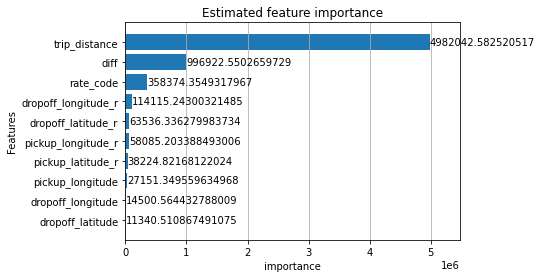

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgb.plot_importance(trained_model['booster'], height=0.8, max_num_features=10, importance_type="gain")
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
ax.set_xlabel('importance')
plt.show()

# How Good is Our Model?

Now that we have a trained model, we need to test it with the 25% of records we held out.

Based on the filtering conditions applied to this dataset, many of the DataFrame partitions will wind up having 0 rows.

This is a problem for XGBoost which doesn't know what to do with 0 length arrays. We'll repartition the data. 

In [24]:
X_train.head()

,day,day_of_week,diff,dropoff_latitude,dropoff_latitude_r,dropoff_longitude,dropoff_longitude_r,h_distance,hour,is_weekend,month,passenger_count,pickup_latitude,pickup_latitude_r,pickup_longitude,pickup_longitude_r,rate_code,trip_distance,year
0,15,4.0,1083000000000,40.750618,40.750000,-73.974785,-73.979996,1.610893,19,0,1,1,40.750111,40.750000,-73.993896,-74.000000,1,1.59,2015
1,10,6.0,1190000000000,40.759109,40.750000,-73.994415,-74.000000,3.924552,20,0,1,1,40.724243,40.719997,-74.001648,-74.010002,1,3.30,2015
2,10,6.0,603000000000,40.824413,40.820000,-73.951820,-73.959999,2.592739,20,0,1,1,40.802788,40.799999,-73.963341,-73.970001,1,1.80,2015
3,10,6.0,112000000000,40.719986,40.709999,-74.004326,-74.010002,0.794628,20,0,1,1,40.713818,40.709999,-74.009087,-74.010002,1,0.50,2015
4,10,6.0,1159000000000,40.742653,40.739998,-74.004181,-74.010002,3.544626,20,0,1,1,40.762428,40.759998,-73.971176,-73.979996,1,3.00,2015


In [25]:
def drop_empty_partitions(df):
    lengths = df.map_partitions(len).compute()
    nonempty = [length > 0 for length in lengths]
    return df.partitions[nonempty]

In [26]:
X_test = taxi_df.query('day >= 25').persist()
X_test = drop_empty_partitions(X_test)

# Create Y_test with just the fare amount
Y_test = X_test[['fare_amount']]

# Drop the fare amount from X_test
X_test = X_test[X_test.columns.difference(['fare_amount'])]

# display test set size
len(X_test)

7905495

In [57]:
dtest = xgb.dask.DaskDMatrix(client, X_test, Y_test)

The following cell yields an error due to .repartition()

In [ ]:
# X_test = taxi_df.query('day >= 25').persist()
# # X_test = drop_empty_partitions(X_test)

# # Create Y_test with just the fare amount
# # Y_test = X_test[['fare_amount']]
# Y_test = X_test[['fare_amount']].repartition(npartitions=4)

# # Drop the fare amount from X_test
# # X_test = X_test[X_test.columns.difference(['fare_amount'])]
# X_test = X_test[X_test.columns.difference(['fare_amount'])].repartition(npartitions=4)

# # display test set size
# len(X_test)

In [27]:
X_test.head()

,day,day_of_week,diff,dropoff_latitude,dropoff_latitude_r,dropoff_longitude,dropoff_longitude_r,h_distance,hour,is_weekend,month,passenger_count,pickup_latitude,pickup_latitude_r,pickup_longitude,pickup_longitude_r,rate_code,trip_distance,year
38,25,0.0,14,40.725559,40.719997,-73.996941,-74.000000,2.413343,0,1,1,1,40.727741,40.719997,-73.994812,-74.000000,1,0.02,2015
39,25,0.0,966,40.737865,40.730000,-74.006546,-74.010002,4.616995,0,1,1,1,40.726765,40.719997,-73.985939,-73.989998,1,1.73,2015
40,25,0.0,758,40.739056,40.730000,-74.008087,-74.010002,2.294490,0,1,1,1,40.743275,40.739998,-73.979988,-73.979996,1,2.25,2015
41,25,0.0,765,40.762470,40.759998,-73.978729,-73.979996,4.059519,0,1,1,1,40.721680,40.719997,-73.988968,-73.989998,1,3.53,2015
42,25,0.0,620,40.801991,40.799999,-73.957085,-73.959999,1.685555,0,1,1,1,40.782360,40.779999,-73.948685,-73.949997,1,2.01,2015


In [58]:
# generate predictions on the test set
prediction = xgb.dask.predict(client, trained_model['booster'], dtest)

In [59]:
type(Y_test['fare_amount']), type(prediction)

(dask.dataframe.core.Series, dask.array.core.Array)

In [63]:
true = Y_test['fare_amount'].compute()
preds = prediction.compute()

In [64]:
squared_error=(preds - true.to_array())**2

# compute the actual RMSE over the full test set
math.sqrt(squared_error.mean())
# inspect the results to make sure our calculation looks right

14.03417775081966

## SAVE THE TRAINED MODEL

In [38]:
# booster = trained_model['booster']  # booster is the trained model
# history = trained_model['history']  # A dictionary containing evaluation results
# # Save the model to file
# booster.save_model('xgboost-model')
# print('Training evaluation history:', history)

Training evaluation history: {'train': {'rmse': [10.847029, 7.667126, 5.461783, 3.94479, 2.921886, 2.251688, 1.829115, 1.576599, 1.429019, 1.347868, 1.298269, 1.272693, 1.25337, 1.241589, 1.235294, 1.228821, 1.225643, 1.222591, 1.220612, 1.21611, 1.214006, 1.212464, 1.21113, 1.207604, 1.206899, 1.206218, 1.205186, 1.203875, 1.202728, 1.200397, 1.198879, 1.196149, 1.195035, 1.193898, 1.190321, 1.185154, 1.184539, 1.182065, 1.180249, 1.178875, 1.178303, 1.176638, 1.175979, 1.174543, 1.173652, 1.172597, 1.171119, 1.168137, 1.166669, 1.166278, 1.165752, 1.164637, 1.163796, 1.154168, 1.151731, 1.150814, 1.14866, 1.147489, 1.146618, 1.146297, 1.14561, 1.144014, 1.14024, 1.137189, 1.13366, 1.133059, 1.131912, 1.130576, 1.130236, 1.129348, 1.127905, 1.127495, 1.123664, 1.122244, 1.118283, 1.118055, 1.116854, 1.115932, 1.11473, 1.1144, 1.113545, 1.112381, 1.111807, 1.111092, 1.108818, 1.103436, 1.100285, 1.099752, 1.099502, 1.098631, 1.097732, 1.096965, 1.096321, 1.096122, 1.095695, 1.093114, 1

## VISUALIZATIONS

In [43]:
X_test_cudf= X_test.compute()

In [44]:
X_test_cudf['fare_amount']= Y_test['fare_amount'].compute()
#X_test_cudf['prediction']= prediction

In [45]:
X_test_pd = X_test_cudf.to_pandas()

In [46]:
X_test_pd.groupby('passenger_count').fare_amount.mean()

passenger_count
1    12.442133
2    12.996991
3    12.603300
4    12.643187
5    12.653585
Name: fare_amount, dtype: float32

In [47]:
X_test_pd['passenger_count'].value_counts()

1    5815646
2    1161410
5     451666
3     326975
4     149798
Name: passenger_count, dtype: int64

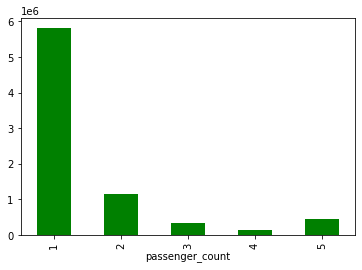

In [48]:
X_test_pd.groupby('passenger_count').size().plot.bar(color ='green')

0


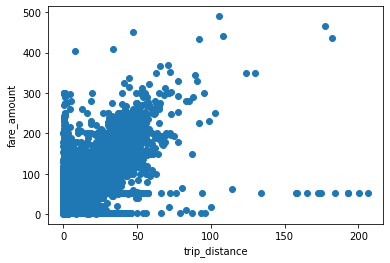

In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

print(mpl.rcParams['agg.path.chunksize'])
mpl.rcParams['agg.path.chunksize'] = 10000

fig, ax = plt.subplots()
ax.set_xlabel('trip_distance')     
ax.set_ylabel('fare_amount') 
ax.scatter(X_test_pd['trip_distance'], X_test_pd['fare_amount'])
plt.show()

10000


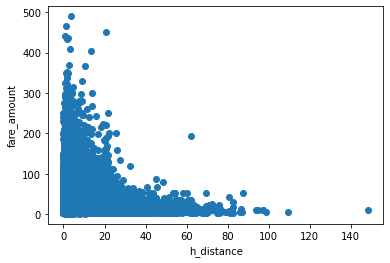

In [51]:
print(mpl.rcParams['agg.path.chunksize'])
mpl.rcParams['agg.path.chunksize'] = 10000

fig, ax = plt.subplots()
ax.set_xlabel('h_distance')     
ax.set_ylabel('fare_amount')   
ax.scatter(X_test_pd['h_distance'], X_test_pd['fare_amount'])
plt.show()

10000


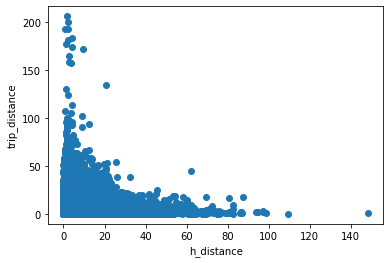

In [52]:
print(mpl.rcParams['agg.path.chunksize'])
mpl.rcParams['agg.path.chunksize'] = 10000

fig, ax = plt.subplots()
ax.set_xlabel('h_distance')     
ax.set_ylabel('trip_distance')   
ax.scatter(X_test_pd['h_distance'], X_test_pd['trip_distance'])
plt.show()

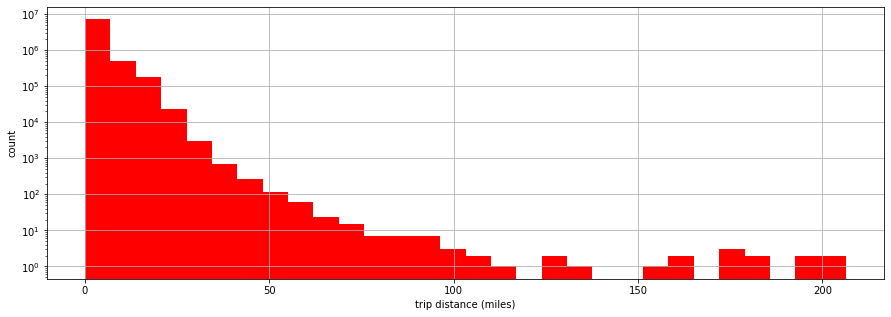

In [54]:
ax = X_test_pd['trip_distance'].hist(bins=30, figsize=(15,5), color='red')
ax.set_yscale('log')
ax.set_xlabel("trip distance (miles)")
ax.set_ylabel("count")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b90136b90>,
      dtype=object)

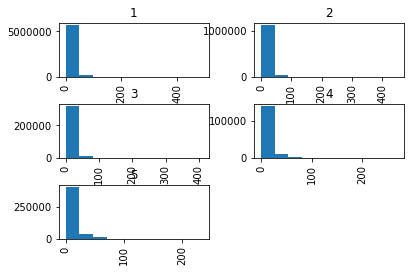

In [116]:
X_test_pd['fare_amount'].hist(by=X_test_pd['passenger_count'])

## VISUALS WITH CUXFILTER

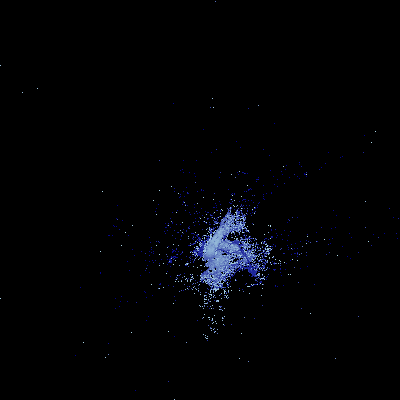

In [71]:
import datashader as ds
import datashader.transfer_functions as tf
from colorcet import fire

# cvs = ds.Canvas(plot_width=500, plot_height=500, x_range=x_range, y_range=y_range)
# agg = cvs.points(X_test_cudf, 'pickup_longitude', 'pickup_latitude', ds.mean('prediction'))
# tf.set_background(tf.shade(agg, cmap=fire),"black")

cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(X_test_cudf, 'pickup_longitude', 'pickup_latitude', ds.mean('fare_amount'))
tf.set_background(tf.shade(agg, cmap=['lightblue', 'darkblue']),"black")

In [214]:
X_test_cudf['day_of_week'].value_counts()

0.0    1198346
1.0    1121176
4.0    1082160
2.0    1077222
6.0    1064061
3.0    1027081
5.0     926086
Name: day_of_week, dtype: int32

In [68]:
#update data_dir if you have downloaded datasets elsewhere
import cuxfilter as cxf
import datashader as ds, pandas as pd
import datashader.transfer_functions as tf
from cuxfilter import DataFrame, themes, layouts
from cuxfilter.charts import bokeh, datashader, panel_widgets
import datashader as ds
import datashader.transfer_functions as tf


cux_df = cxf.DataFrame.from_dataframe(X_test_cudf)

cux_df.data['fare_amount'] = cux_df.data['fare_amount'].astype('float32')

label_map = {0.0: 'Sat', 1.0: 'Sun',    2.0: 'Mon',    3.0: 'Tues',    4.0: 'Wed',   5.0: 'Thu',    6.0: 'Fri'}
#red_blue_palette = [(49,130,189),(107,174,214), (123, 142, 216), (226,103,152), (255,0,104) , (50,50,50)]
red_yellow_palette = [(236,155,0), (236,202,0), (236,0,0),(236,36,0), (236,83,0)]

#declare charts
chart1 = cxf.charts.datashader.scatter_geo(x='pickup_longitude', y='pickup_latitude', aggregate_col='fare_amount', aggregate_fn='mean', color_palette=fire)
chart2 = cxf.charts.panel_widgets.multi_select('day_of_week')
chart3 = cxf.charts.bokeh.bar('day_of_week', x_label_map=label_map)
fare_vs_dist = cxf.charts.datashader.scatter(x='h_distance', y='fare_amount', x_range=(X_test_cudf['h_distance'].min(), X_test_cudf['h_distance'].max()), 
                                             y_range=(X_test_cudf['fare_amount'].min(), X_test_cudf['fare_amount'].max()))

#heatmap = cxf.charts.datashader.heatmap(x='pickup_longitude', y='pickup_latitude', aggregate_col='prediction', aggregate_fn='mean', color_palette=fire)

#declare dashboard

d = cux_df.dashboard([chart1, chart2, chart3, fare_vs_dist], layout=cxf.layouts.feature_and_double_base,theme = cxf.themes.light, 
                     title='Taxi Dataset', data_size_widget=True)

In [197]:
d

#### cuxfilter DashBoard
    
    [title] Markdown(str)
    [chart1] Column(sizing_mode='scale_both', width=1600)
    [0] Bokeh(Figure)
    [chart2] Column(sizing_mode='scale_both', width=800)
    [0] Bokeh(Figure)
    [1] RangeSlider(end=6.0, sizing_mode='scale_width', start=0.0, step=1, value=(0.0, 6.0), width=800)
    [chart3] Column(sizing_mode='scale_both', width=800)
    [0] Bokeh(Figure)
    [widgets] Column
    [0] Column(css_classes=['non-handle-temp'], sizing_mode='scale_both')
        [0] FloatSlider(bar_color='#4292c6', end=7905694, name='Data Points selected', sizing_mode='scale_both', start=0, value=7905694, width=280)
    [1] Column(sizing_mode='scale_both', width=400)
        [0] MultiSelect(css_classes=['custom-dropdown'], height=200, name='day_of_week', options=[nan, 0.0, 1.0, ...], sizing_mode='scale_both', value=[''], width=280)

In [ ]:
d.show(notebook_url='10.110.46.158:8888')

In [70]:
d.stop()